# Ouroboros Leios DeltaQ analysis

<div class="alert alert-block alert-warning"><b>Note:</b> I had to patch some references in the dqsd-workbench, run this notebook with: <a href="https://github.com/yveshauser/dqsd-workbench">https://github.com/yveshauser/dqsd-workbench</a></div>

*Ouroboros Leios* is a protocol extending a base consensus protocol to increase the throughput of the base layer, in our case *Ouroboros Praos*. 

The DeltaQ analysis of *Ouroboros Leios* is based on work for *Ouroboros Paras*, see referenced paper below.

__[Ouroborus Leios](https://leios.cardano-scaling.org/)__

__[Mind Your Outcomes: Quality-Centric Systems Development, 2022](https://iohk.io/en/research/library/papers/mind-your-outcomes-the-dqsd-paradigm-for-quality-centric-systems-development-and-its-application-to-a-blockchain-case-study/)__

In [1]:
import Data.Ratio
import Text.Printf

import DeltaQ.Workbench.Numeric

## Block diffusion

Numbers for modelling block diffusion are taken from Table 1 in the referenced paper and are displayed here:

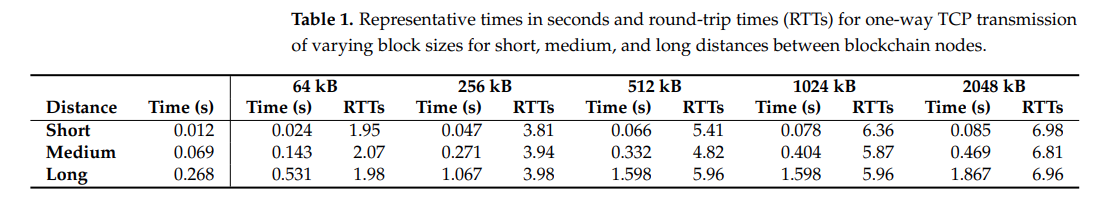

We assume the distances __short__, __medium__ and __long__ are equally distributed which allows to create the following DeltaQ expression for the *MTU* (message transfer unit):

In [2]:
oneMTU :: DeltaQ
oneMTU = fromQTA [(1 % 3, 0.012), (2 % 3, 0.069), (3 % 3, 0.268)]

In [3]:
printf "DeltaQ expression for one MTU (message transport unit): %s" (show oneMTU)

DeltaQ expression for one MTU (message transport unit): δ⎣1.2e-2⎤ (1⇋2) δ⎣6.9e-2⎤ (1⇋1) δ⎣0.268⎤

And equivallently for 64K messages:

In [4]:
blockBody64K :: DeltaQ
blockBody64K = fromQTA [(1 % 3, 0.024), (2 % 3, 0.143), (3 % 3, 0.531)]

In [5]:
printf "DeltaQ expression for 64K messages: %s" (show blockBody64K)

DeltaQ expression for 64K messages: δ⎣2.4e-2⎤ (1⇋2) δ⎣0.143⎤ (1⇋1) δ⎣0.531⎤

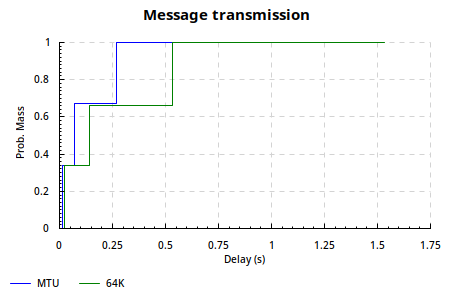

In [6]:
plotDQs "Message transmission" [("MTU", oneMTU), ("64K", blockBody64K)]

#### Block header request/reply

In [7]:
headerRequestReply :: DeltaQ
headerRequestReply = oneMTU ⊕ oneMTU

#### Block body request/reply

For Leios there are different kind of blocks
* Input blocks
* Endorser blocks
* Ranking blocks

Input block contain transactions are supposed to be __large__, whereas endorser blocks contain references to input blocks and are therefore __small__

In [8]:
bodyRequestReply :: DeltaQ
bodyRequestReply = oneMTU ⊕ oneMTU

In [9]:
body64KRequestReply :: DeltaQ
body64KRequestReply = oneMTU ⊕ blockBody64K

Helper functions

In [10]:
combine :: (Real a, Fractional a) => [(a, DeltaQ)] -> DeltaQ
combine [(p, dq), (_, dq')] = (⇋) (toRational $ p / 100) dq dq'
combine ((p, dq) : rest) = (⇋) (toRational $ p / 100) dq (combine rest)
combine [] = (∅)

In [11]:
multiHop :: Int -> DeltaQ -> DeltaQ
multiHop n dq = iterate (dq ⊕) dq !! max 0 (n - 1)

In [12]:
multihops :: DeltaQ -> [DeltaQ]
multihops dq = (`multiHop` dq) <$> [1 ..]

In [13]:
hopsProba :: [Double] -> DeltaQ -> [(Double, DeltaQ)]
hopsProba l dq = zip (scanl1 (+) l <> [0]) (multihops dq)

#### Model for average degree 15

In [14]:
pathLengthsDistributionDegree15 :: [Double]
pathLengthsDistributionDegree15 = [0.60, 8.58, 65.86, 24.95]

In [15]:
hopsProba15 :: DeltaQ -> [(Double, DeltaQ)]
hopsProba15 = hopsProba pathLengthsDistributionDegree15

#### Model for average degree 10

In [ ]:
pathLengthsDistributionDegree10 :: [Double]
pathLengthsDistributionDegree10 = [0.40, 3.91, 31.06, 61.85, 2.78]

In [ ]:
hopsProba10 :: DeltaQ -> [(Double, DeltaQ)]
hopsProba10 = hopsProba pathLengthsDistributionDegree10

### Diffuse IB (input block)

In [ ]:
oneIBBlockDiffusion :: DeltaQ
oneIBBlockDiffusion = headerRequestReply ⊕ body64KRequestReply

In [ ]:
diffuseIB :: DeltaQ
diffuseIB = combine (hopsProba15 oneIBBlockDiffusion)

### Diffuse EB (input block)

In [ ]:
oneEBBlockDiffusion :: DeltaQ
oneEBBlockDiffusion = headerRequestReply ⊕ bodyRequestReply

In [ ]:
diffuseEB :: DeltaQ
diffuseEB = combine (hopsProba15 oneEBBlockDiffusion)

## Results

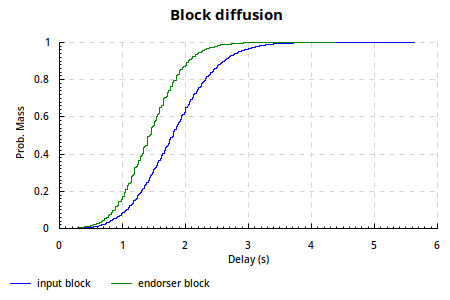

In [ ]:
plotDQs "Block diffusion" [("input block", diffuseIB), ("endorser block", diffuseEB)]